In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
def load_and_preprocess_data():
    # Load dataset from UCI
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv"
    data = pd.read_csv(url)
    
    # Handle missing values
    data = data.dropna(subset=['pm2.5'])
    
    # Advanced feature engineering
    data['date'] = pd.to_datetime(data[['year', 'month', 'day', 'hour']])
    data['day_of_week'] = data['date'].dt.dayofweek
    data['month'] = data['date'].dt.month
    data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)
    
    # Trigonometric features for cyclical time features
    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    
    # Select features
    features = [
        'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 
        'hour_sin', 'hour_cos', 'day_of_week', 
        'month_sin', 'month_cos', 'is_weekend'
    ]
    
    X = data[features]
    
    # Binary classification (high vs low PM2.5)
    # Use 75th percentile as threshold for more challenging classification
    threshold = data['pm2.5'].quantile(0.75)
    y = (data['pm2.5'] > threshold).astype(int)
    
    # Train-test split with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Feature selection
    selector = SelectKBest(f_classif, k=8)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

In [3]:
def train_and_evaluate_xgboost():
    # Load preprocessed data
    X_train, X_test, y_train, y_test = load_and_preprocess_data()
    
    # Advanced XGBoost parameters for high accuracy
    params = {
        'n_estimators': 300,  # Increased from default
        'max_depth': 7,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'min_child_weight': 3,
        'gamma': 0.1,
        'reg_alpha': 0.1,
        'reg_lambda': 1.0,
        'scale_pos_weight': 1,  # Balance positive and negative weights
        'random_state': 42
    }
    
    # Cross-validation for more robust parameter tuning
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize and train XGBoost
    clf = xgb.XGBClassifier(**params)
    
    # Perform cross-validation
    cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
    print("Cross-validation Accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))
    
    # Fit on full training data
    clf.fit(X_train, y_train, 
            eval_set=[(X_test, y_test)],
            early_stopping_rounds=20,
            verbose=False)
    
    # Predictions
    y_pred = clf.predict(X_test)
    
    # Detailed evaluation
    accuracy = accuracy_score(y_test, y_pred)
    print("\nXGBoost Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    
    return clf




Cross-validation Accuracy: 0.84 (+/- 0.00)


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



XGBoost Results:
Accuracy: 0.8391

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      6272
           1       0.74      0.55      0.63      2080

    accuracy                           0.84      8352
   macro avg       0.80      0.74      0.76      8352
weighted avg       0.83      0.84      0.83      8352



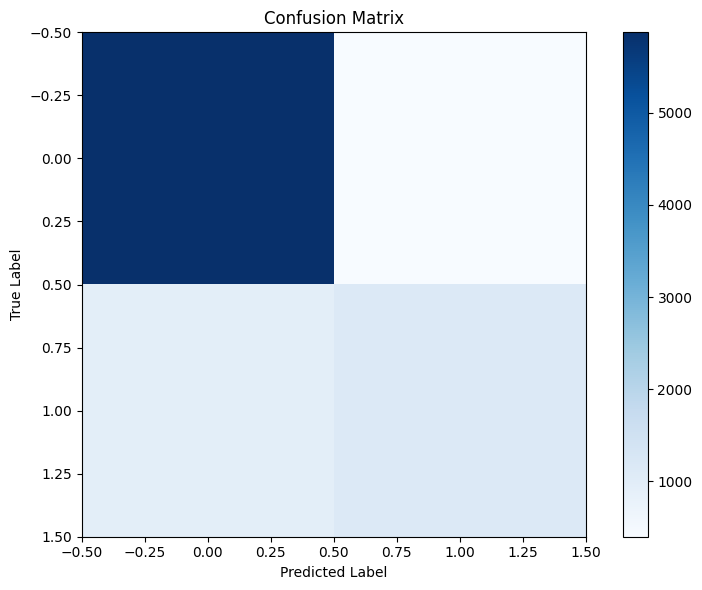

In [4]:
if __name__ == '__main__':
    model = train_and_evaluate_xgboost()